In [96]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data, get_outliers_inliers
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
#warnings
import warnings
warnings.filterwarnings('ignore')


In [97]:
data, is_anomaly = generate_data(
    n_features=6,
    train_only=True,
    random_state=1234
    )


data = pd.DataFrame(data, columns = ['x1','x2','x3','x4','x5', 'x6'])
data['class'] = is_anomaly

In [98]:
data.tail()

,x1,x2,x3,x4,x5,x6,class
995,-0.165684,0.703523,-2.538488,-2.683015,0.917457,-1.179865,1.0
996,-1.714286,1.174339,1.861243,0.162709,2.932199,2.279533,1.0
997,1.894644,0.173433,-2.010234,1.496773,1.165574,1.310984,1.0
998,-2.139861,1.663331,0.105054,2.706761,-1.165058,1.856531,1.0
999,1.454473,-0.996308,0.681930,-2.471733,0.202842,0.953513,1.0


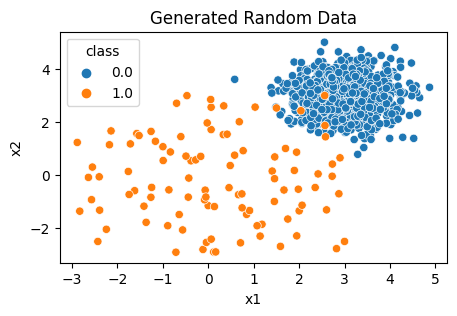

In [99]:
plt.rcParams["figure.figsize"] = (5,3)
np.random.seed(1234)
sns.scatterplot(
    data = data, 
    x = 'x1', 
    y = 'x2', 
    hue = 'class'
)

plt.title("Generated Random Data")
plt.show()

In [100]:
#train isolation forest
clf = IsolationForest(max_samples=100, random_state=1234)
clf.fit(data.drop('class', axis=1))
predictions=clf.predict(data.drop('class', axis=1))
anomaly_score = clf.decision_function(data.drop('class', axis=1))
#map predictions 1 to 0, -1 to 1
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1

#add the predictions as a column to data
data['predicted_class'] = predictions
data['anomaly_score'] = anomaly_score

<Axes: xlabel='x1', ylabel='x2'>

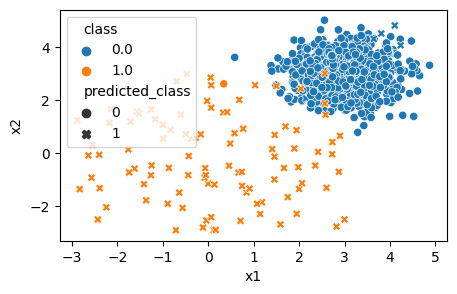

In [101]:
sns.scatterplot(
    data = data, 
    x = 'x1', 
    y = 'x2', 
    hue = 'class',
    style = 'predicted_class'
)

<Axes: xlabel='predicted_class', ylabel='anomaly_score'>

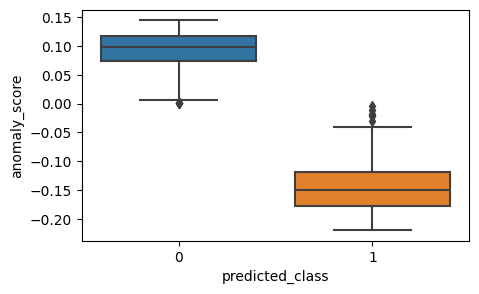

In [102]:
#plot boxplot for anomaly score
sns.boxplot(
    data = data,
    x = 'predicted_class',
    y = 'anomaly_score'
)

In [103]:
def isolation_Forest(parameters):
    model=IsolationForest(**parameters)
    model.fit(data.drop('class', axis=1))
    predictions=model.predict(data.drop('class', axis=1))
    anomaly_score = model.decision_function(data.drop('class', axis=1))
    #map predictions 1 to 0, -1 to 1
    predictions[predictions == 1] = 0
    predictions[predictions == -1] = 1

    #add the predictions as a column to data
    data['predicted_class'] = predictions
    data['anomaly_score'] = anomaly_score

    return predictions, anomaly_score

In [104]:
#set a parameter grid for the isolation forest
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_samples': [50, 100, 200, 500],
    'contamination': [0.01, 0.05, 0.1, 0.2]
}

#set a list to store the results
results = []

#loop through the parameter grid

for n_estimators in param_grid['n_estimators']:

    for max_samples in param_grid['max_samples']:

        for contamination in param_grid['contamination']:

            parameters = {
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'contamination': contamination,
                'random_state': 1234
            }

            predictions, anomaly_score = isolation_Forest(parameters)

            results.append({
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'contamination': contamination,
                'accuracy': accuracy_score(data['class'], predictions),
                'f1': f1_score(data['class'], predictions),
                'auc': roc_auc_score(data['class'], anomaly_score)
            })